In [57]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import math
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
from torch import optim
from tqdm import tqdm
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [58]:
meteoData = pd.read_csv("podaci_final_VV_popunjeno_bezH.csv")
pollutionData = pd.read_csv("pollutionData.csv")

In [59]:
del pollutionData['Unnamed: 0']
del pollutionData['MernaStanica']

In [60]:
pollutionData.columns = ['DateTime', 'B', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']

In [61]:
pollutionData = pollutionData.merge(meteoData, how = 'inner', on = "DateTime")

In [62]:
del pollutionData['DateTime']

In [63]:
yData = pollutionData[['B', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']]

In [64]:
xData = pollutionData.drop(['B', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2'], axis = 1)

In [65]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
                    
        self.fnn = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            
            nn.Linear(64, 7),
            nn.ReLU()
        )
        
    def forward(self, input):
        return self.fnn(input)

In [66]:
def mseLoss(target, output):
    batchSize, _, _ = target.shape
    # 32 x 1 x 7
    mseSumm = 0
    for _ in range(batchSize):
        mseSumm = output - target

In [67]:
def trainLoop(fnn, trainLoader, valLoader):
    fnn.train()
    optimizer = optim.Adam(fnn.parameters())
    #criterion = torch.nn.MSELoss()
    criterion = torch.nn.L1Loss()
    
    counterTrain = []
    lossHistoryTrain = []

    counterVal = []
    lossHistoryVal = []
    epochsSinceLastImprovement = 0
    bestLoss = None
    
    EPOCHS = 300
    
    for epoch in tqdm(range(EPOCHS)):
        
        epochLoss = 0
        
        for batch_idx, (data, target) in enumerate(trainLoader):

            optimizer.zero_grad()

            data, target = data.to(device), target.to(device)

            output = fnn(data)
            loss = criterion(output, target)
            
            epochLoss += loss.item()
            loss.backward()
            optimizer.step()
        
        counterTrain.append(epoch)
        lossHistoryTrain.append(epochLoss/len(trainLoader))
        
        with torch.no_grad():

            validationLoss = 0

            for batch_idx, (data, target) in enumerate(valLoader):
                
                data, target = data.to(device), target.to(device)

                output = fnn(data)
                loss = criterion(output, target)

                validationLoss += loss.item()
        
        counterVal.append(epoch)
        lossHistoryVal.append(validationLoss/len(valLoader))
        
        
        if bestLoss is None:
            bestLoss = validationLoss
            bestModel = fnn.state_dict()

        if validationLoss >= bestLoss:
            epochsSinceLastImprovement += 1
            if epochsSinceLastImprovement >= 15:
                print(f"Early stopped at epoch {epoch}!")
                fnn.load_state_dict(bestModel)
                break
        else:
            epochsSinceLastImprovement = 0
            bestLoss = validationLoss
            bestModel = fnn.state_dict()
            
            
    plt.plot(counterTrain, lossHistoryTrain)
    plt.plot(counterVal, lossHistoryVal)
    plt.legend(['mae_train', 'mae_val'])
    plt.xlabel('EPOCHS')
    plt.ylabel('MAE')
    plt.show()

In [68]:
def testLoop(fnn, testLoader):
    fnn.eval()
    mseLoss = 0
    maeLoss = 0
    
    optimizer = optim.Adam(fnn.parameters())
    criterion = torch.nn.MSELoss()
    criterionMAE = torch.nn.L1Loss()
    
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = fnn(data)
            
            loss = criterion(output, target)
            mseLoss += loss.item()
            
            loss = criterionMAE(output, target)
            maeLoss += loss.item()

    mseLoss /= len(testLoader)
    maeLoss /= len(testLoader)

    return mseLoss, maeLoss

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
model = FullyConnected()
model.to(device)

FullyConnected(
  (fnn): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=7, bias=True)
    (10): ReLU()
  )
)

In [71]:
yData.isna().sum()

B       0
CO      0
NO2     0
O3      0
PM10    0
PM25    0
SO2     0
dtype: int64

In [72]:
yData = [[y] for y in yData.values]
yData = torch.Tensor(yData)

In [73]:
xData = [[y] for y in xData.values]
xData = torch.Tensor(xData)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(xData, yData, random_state = 12, test_size = 0.2)

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 12, test_size = 0.25)

In [76]:
trainDataset = data_utils.TensorDataset(X_train, y_train)
testDataset = data_utils.TensorDataset(X_test, y_test)
valDataset = data_utils.TensorDataset(X_val, y_val)

In [77]:
batchSize = 64

In [78]:
trainLoader = DataLoader(trainDataset, shuffle=True, num_workers=0, batch_size=batchSize)

In [79]:
testLoader = DataLoader(testDataset, shuffle=True, num_workers=0, batch_size=batchSize)

In [80]:
valLoader = DataLoader(valDataset,shuffle=True, num_workers=0, batch_size=batchSize)

 39%|██████████████████████████████▉                                                 | 116/300 [03:00<04:46,  1.55s/it]

Early stopped at epoch 116!


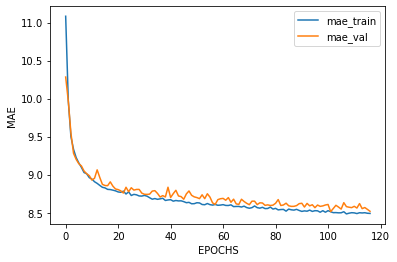

In [81]:
trainLoop(model, trainLoader, valLoader)

In [82]:
testLoss = testLoop(model, testLoader)

In [83]:
testLoss

(203.6284080861146, 8.278167650489609)

In [84]:
torch.save(model.state_dict(), "modelPollution_" + str(round(testLoss[1], 2)))